
Reads a CSV file containing protein IDs and GO terms.
Generates a random sequence for each protein.



In [1]:
import random

# Input CSV file path
csv_file = "processed_mappings.csv"

# Output FASTA file path
fasta_file = "protein_sequences.fasta"

def generate_random_sequence(length=50): #Creates a random sequence of amino acids of the given length.
    amino_acids = "ACDEFGHIKLMNPQRSTVWY" 
    return "".join(random.choices(amino_acids, k=length))

def create_fasta_from_csv(csv_path, fasta_path):#Converts CSV entries into FASTA format.
    fasta_entries = []
    with open(csv_path, "r") as file:
        next(file) #Skips the header (next(file)).
        for line in file:
            protein_id, go_terms = line.strip().split(",")
            sequence = generate_random_sequence()
            fasta_entries.append(f">{protein_id} {go_terms}\n{sequence}\n") # Formats it into FASTA format 
    
    with open(fasta_path, "w") as fasta_file:
        fasta_file.writelines(fasta_entries)#

create_fasta_from_csv(csv_file, fasta_file)
print(f"FASTA file generated: {fasta_file}")


FASTA file generated: protein_sequences.fasta


In [ ]:
from collections import Counter
import pandas as pd

# Input FASTA file
fasta_file = "protein_sequences.fasta"

def parse_fasta(file_path): #Reads the FASTA file and stores sequences in a dictionary
    sequences = {}
    with open(file_path, "r") as file:
        protein_id = None
        for line in file:
            line = line.strip()
            if line.startswith(">"):
                protein_id = line.split()[0][1:]   #>P12345 GO:0008150
                sequences[protein_id] = ""    #Initializes an empty string for the sequence corresponding to the protein ID.
            else:
                sequences[protein_id] += line  
    return sequences

def calculate_aac(sequence): #Calculates the Amino Acid Composition (AAC) for a given protein sequence.
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    total_length = len(sequence)
    counts = Counter(sequence)
    return [counts[aa] / total_length for aa in amino_acids]

sequences = parse_fasta(fasta_file)
aac_features = []

for protein_id, sequence in sequences.items():
    features = calculate_aac(sequence)
    aac_features.append([protein_id] + features)

columns = ["Protein_ID"] + list("ACDEFGHIKLMNPQRSTVWY")
aac_df = pd.DataFrame(aac_features, columns=columns)

aac_df.to_csv("aac_features.csv", index=False)
print("AAC features saved to aac_features.csv!")


AAC features saved to aac_features.csv!


Test Accuracy: 0.94

Classification Report:
                                                                                                               precision    recall  f1-score   support

                                                                                        GO:0000166;GO:0003723       0.96      1.00      0.98        22
                                                                                                   GO:0003677       0.89      0.96      0.92        25
                                                                             GO:0003677;GO:0000981;GO:0008270       0.96      1.00      0.98        27
                                                                                                   GO:0003682       0.96      0.96      0.96        26
                                                                                        GO:0003682;GO:0003677       1.00      0.97      0.99        37
                                                 

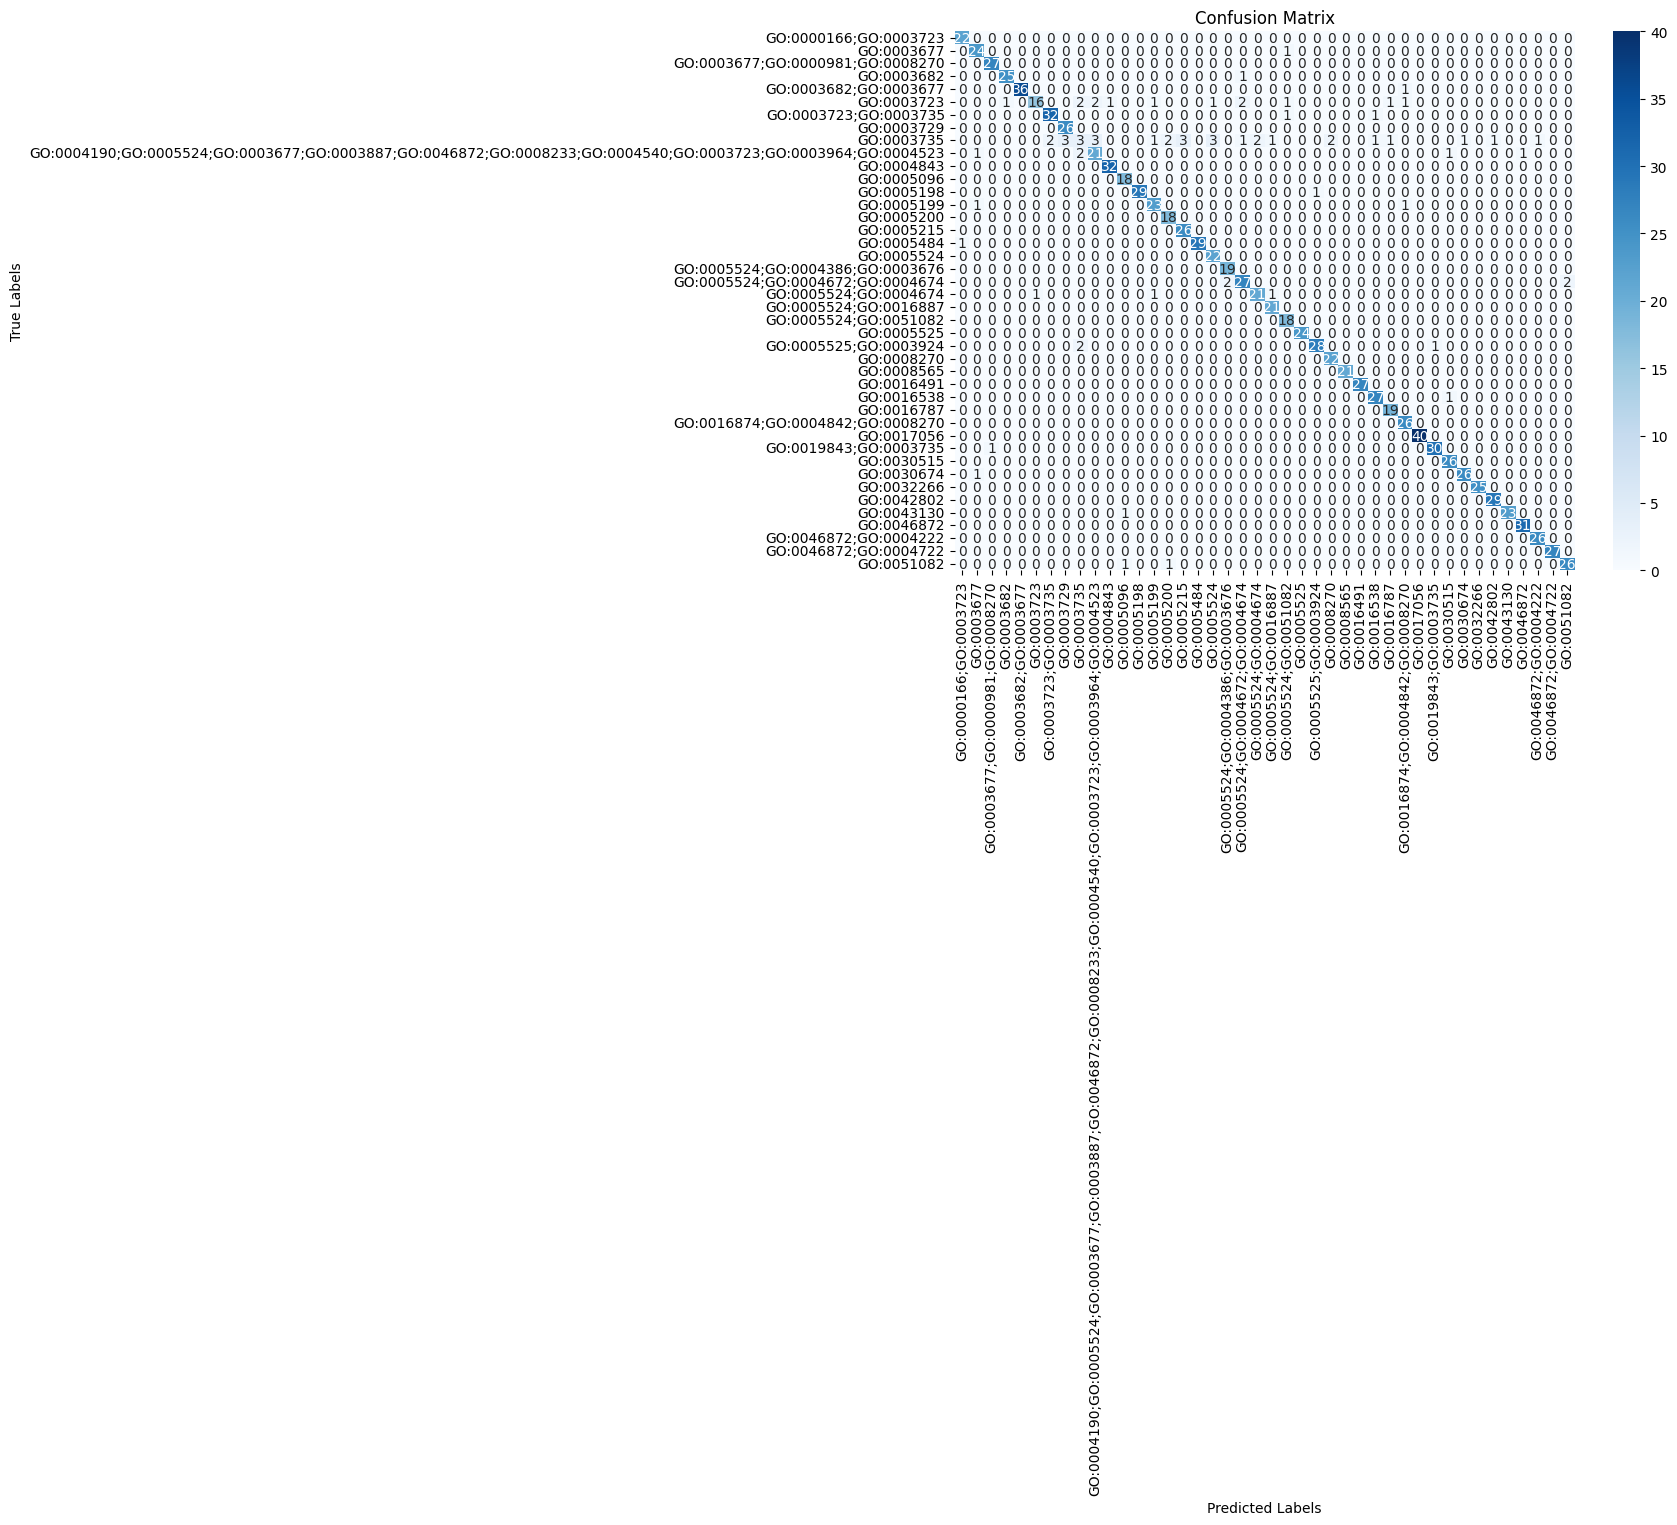

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

features_file = "aac_features.csv"
labels_file = "processed_mappings.csv"

# Load feature data
aac_df = pd.read_csv(features_file)

labels_df = pd.read_csv(labels_file)
data = aac_df.merge(labels_df, on="Protein_ID")

filtered_data = data.groupby("GO_Terms").filter(lambda x: len(x) >= 10)  #  Filtering Data Based on GO Terms Count
X = filtered_data.iloc[:, 1:-1]  # All AAC columns
y = filtered_data["GO_Terms"]    # GO_Terms column label column for classification.

label_encoder = LabelEncoder()   #encodes the labels (GO terms) as numerical values.
y_encoded = label_encoder.fit_transform(y)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)




# Train accuracy
y_train_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Test accuracy
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


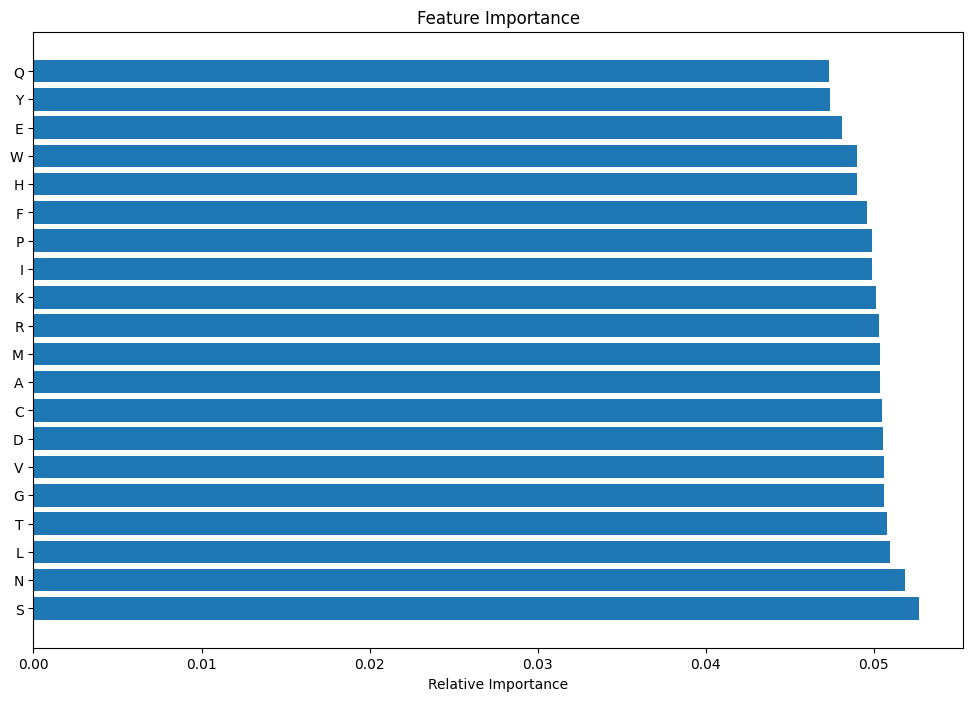

In [5]:
# Feature Importance Plot
importances = clf.feature_importances_ 
indices = importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importance")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [X.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()


# Accuracy per Class
A bar plot showing the performance (accuracy, precision, recall, and F1 score) for each class.

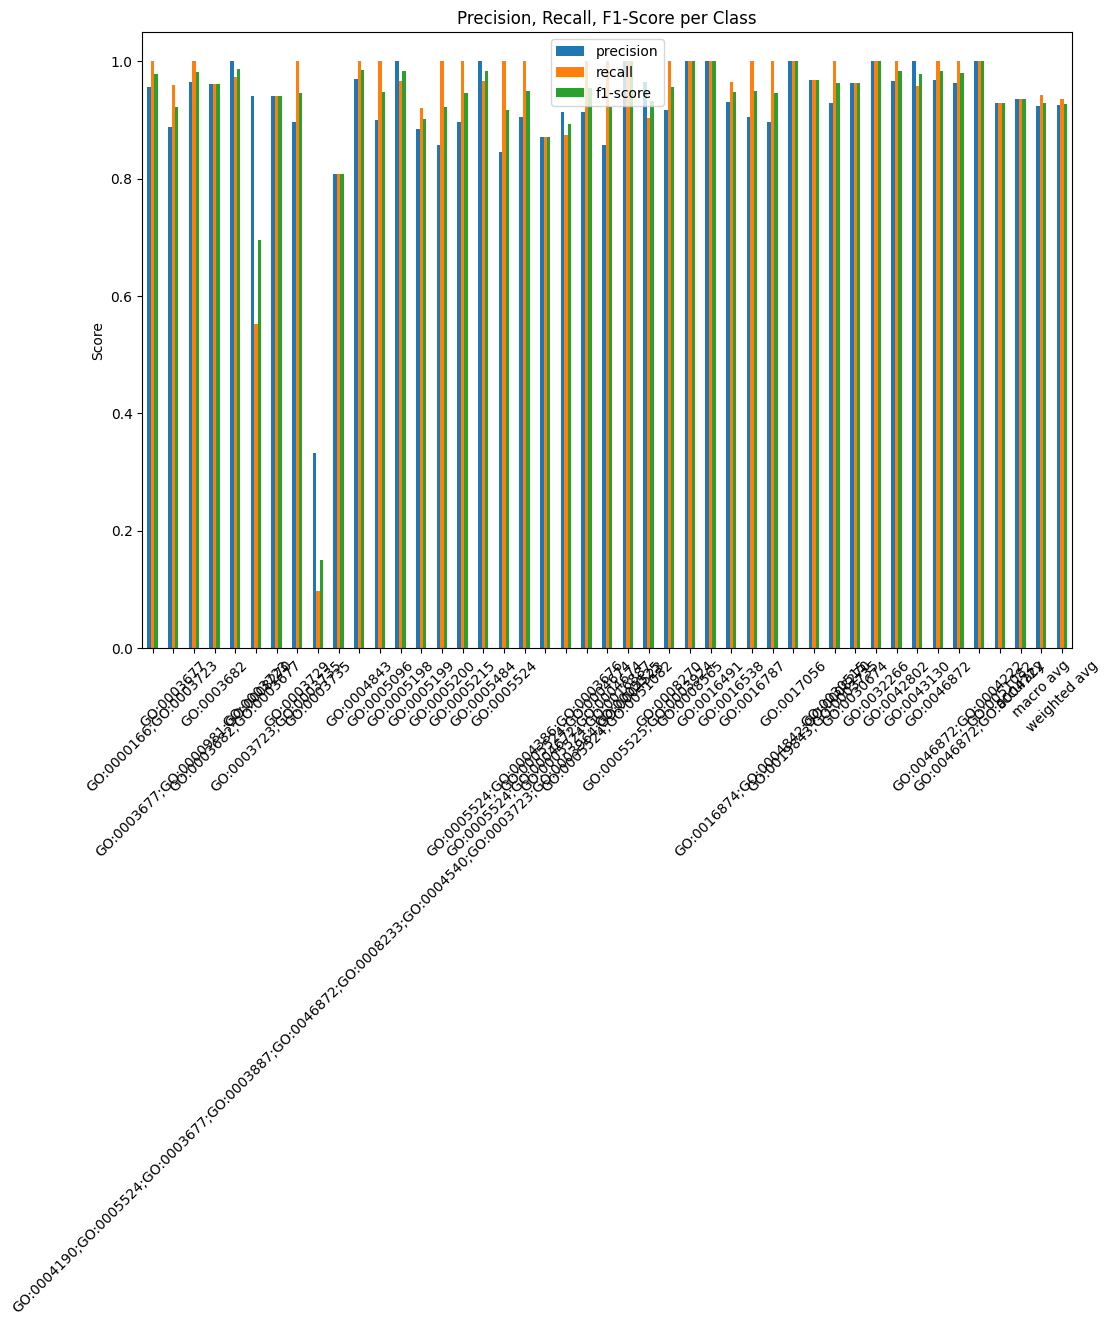

In [4]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True)

class_report_df = pd.DataFrame(report).transpose()

class_report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 8))
plt.title("Precision, Recall, F1-Score per Class")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()
